Train on 450 samples, validate on 50 samples
Epoch 1/1000
450/450 [==============================] - 3s 7ms/sample - loss: 0.0031 - val_loss: 0.0016
Epoch 2/1000
450/450 [==============================] - 0s 257us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 3/1000
450/450 [==============================] - 0s 242us/sample - loss: 0.0016 - val_loss: 0.0013
Epoch 4/1000
450/450 [==============================] - 0s 236us/sample - loss: 0.0014 - val_loss: 0.0010
Epoch 5/1000
450/450 [==============================] - 0s 238us/sample - loss: 0.0011 - val_loss: 8.9466e-04
Epoch 6/1000
450/450 [==============================] - 0s 237us/sample - loss: 9.2080e-04 - val_loss: 7.4216e-04
Epoch 7/1000
450/450 [==============================] - 0s 230us/sample - loss: 7.8613e-04 - val_loss: 6.1499e-04
Epoch 8/1000
450/450 [==============================] - 0s 241us/sample - loss: 6.8304e-04 - val_loss: 5.3638e-04
Epoch 9/1000
450/450 [==============================] - 0s 236us/sample - loss: 5

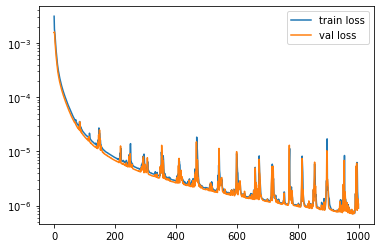

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

cur_path = os.getcwd()
os.makedirs('./CNN_Sim', mode=0o777, exist_ok=True)
work_dir = os.getcwd() + '/CNN_Sim/'
os.makedirs(work_dir + 'ckpt', mode=0o777, exist_ok=True)
ckpt_dir = work_dir + 'ckpt/'

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, ReLU, Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


# latent_size = 16
class CNN_sim(Model):
    def __init__(self, input_size, num_filter, dCNN_dilations):
        super(CNN_sim, self).__init__()
        self.input_size = input_size
        self.num_filter = num_filter
        self.dCNN_dilations = dCNN_dilations
        self.activation = 'relu'
        
        self.encoder = self.encoder_net()
        self.decoder = self.decoder_net()
        self.processor = self.processor_net()
    
    def conv_Block(self, x, BN, activation, filters):
        for i in range(1):
            x = Conv2D(filters=int(filters), kernel_size = (3, 3), activation=activation, padding='same')(x)
        if BN:
            x = BatchNormalization()(x)
        return x

    def residual_block(self, x, filters, dilation_rates):
#         print('x_shortcut is: ', x)
        y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', dilation_rate=dilation_rates[0])(x)
        y = ReLU()(y)
        y = Conv2D(filters=filters, kernel_size=(3,3), padding='same', dilation_rate=dilation_rates[1])(y)
        y = ReLU()(y)
        out = Add()([x, y])
#         print('after residual block, out is: ', out)
        out = ReLU()(out)
        return out

    def grouped(self, iterable, n):
        "s -> (s0,s1,s2,...sn-1), (sn,sn+1,sn+2,...s2n-1), (s2n,s2n+1,s2n+2,...s3n-1), ..."
        return zip(*[iter(iterable)]*n)
    
    def encoder_net(self):
        BN = False
        inputs = Input(shape=(self.input_size, self.input_size, 1), name='Encoder_input')
        x = inputs
        for i in range(2):  
            x = self.conv_Block(x, BN, None, self.num_filter)
            x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same')(x)
        encoder = Model(inputs=[inputs], outputs=[x])
        return encoder
    
    def decoder_net(self):
        BN = False
        inputs = Input(shape=(self.input_size//4, self.input_size//4, self.num_filter), name='Decoder_input')
        x = inputs
        for i in range(2):
            x = self.conv_Block(x, BN, None, self.num_filter)
            x = UpSampling2D()(x)
        x = Conv2D(filters=1, kernel_size=(3,3), padding='same')(x)
        decoder = Model(inputs=[inputs], outputs=[x])
        return decoder
    
    def processor_net(self):
        inputs = Input(shape=(self.input_size//4, self.input_size//4,num_filter))
        x = inputs
        x = Conv2D(filters=int(num_filter), kernel_size=(3,3), padding='same', dilation_rate=1)(x)
        x = ReLU()(x)
        for dCNN_dilation_1, dCNN_dilation_2 in self.grouped(self.dCNN_dilations[1:], 2):
            dCNN_dilation = [dCNN_dilation_1, dCNN_dilation_2]
#             print('dCNN_dilation is: ', dCNN_dilation)
            x = self.residual_block(x, num_filter, dCNN_dilation)
        processor = Model(inputs=[inputs], outputs=[x])
        return processor
    
    def call(self, x):
#         print('x shape is: ', x)
        x = self.encoder(x)
#         print('After encoding, x shape is: ', x)
        x = self.processor(x)
#         print('After processing, x shape is: ', x)
        x = self.decoder(x)
#         print('After decoding, x shape is: ', x)
        return x
        
#     def net(self):
#         net = Sequential([self.encoder, self.processor, self.decoder])
#         return net
    
    def encode(self, x):
        x = self.encoder(x)
        return x        

x_train = np.load(cur_path + '/data/power_maps_0_500_64.npz')['arr_0'][:, :, :, None][:, ::4, ::4, :]

P_max = x_train.max()
P_min = x_train.min()
x_train = (x_train - P_min) / (P_max - P_min)

test_idx = np.random.choice(x_train.shape[0], x_train.shape[0]//10, replace=False)
train_idx = np.setxor1d(np.arange(x_train.shape[0]), test_idx)

my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir = work_dir + '/logs'),
]

input_size = 64
num_filter = 48
dCNN_dilations = [1, 2, 4, 8, 4, 2, 1]
optimizer = Adam(lr=0.0003)

CNN_SIM = CNN_sim(input_size, num_filter, dCNN_dilations)
CNN_SIM.compile(optimizer=optimizer, loss='mse')
history = CNN_SIM.fit(x_train[train_idx, :,:,:], x_train[train_idx, :,:,:],
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(x_train[test_idx, :,:,:], x_train[test_idx, :,:,:]),
                callbacks=my_callbacks)

# history = autoencoder.fit(x_train[train_idx, :,:,:], x_train[train_idx, :,:,:],
#                 epochs=5,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_train[test_idx, :,:,:], x_train[test_idx, :,:,:]),
#                 callbacks=my_callbacks)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(train_loss)
ax.semilogy(val_loss)
ax.legend(['train loss', 'val loss'])
plt.savefig(work_dir + 'loss')

In [3]:
CNN_SIM.summary()

Model: "cnn_sim"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 16, 16, 48)        21264     
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 1)         42001     
_________________________________________________________________
model_2 (Model)              (None, 16, 16, 48)        145488    
Total params: 208,753
Trainable params: 208,753
Non-trainable params: 0
_________________________________________________________________



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



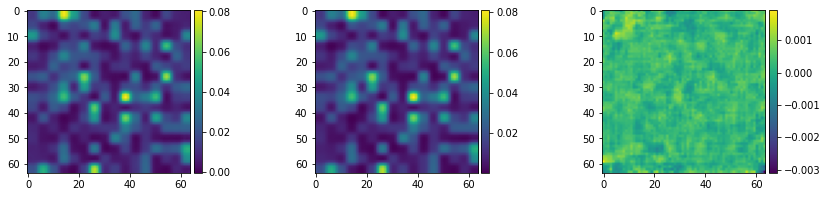

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


idx = np.random.choice(x_train.shape[0])

pred = CNN_SIM(x_train[idx:idx+1, :, :, :])

fig = plt.figure(figsize=(15,3))
plt.subplots_adjust(wspace=0.1)
ax = fig.add_subplot(131)
im = ax.imshow(pred[0, :, :])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

ax = fig.add_subplot(132)
im = ax.imshow(x_train[idx, :, :])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

ax = fig.add_subplot(133)
im = ax.imshow((x_train[idx, :, :] - pred[0, :, :]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)


In [4]:
x_train.shape

(500, 64, 64, 1)

dCNN_dilation is:  [2, 4]
x_shortcut is:  Tensor("re_lu_41/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
after residual block, out is:  Tensor("add_12/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
dCNN_dilation is:  [8, 4]
x_shortcut is:  Tensor("re_lu_44/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
after residual block, out is:  Tensor("add_13/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
dCNN_dilation is:  [2, 1]
x_shortcut is:  Tensor("re_lu_47/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
after residual block, out is:  Tensor("add_14/Identity:0", shape=(None, 256, 256, 48), dtype=float32)


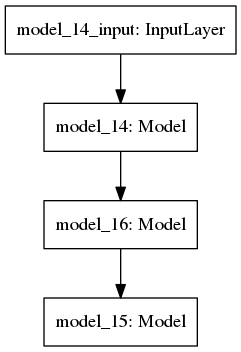

In [10]:
CNN_Sim = CNN_sim(input_size, num_filter)
plot_model(CNN_Sim.net())

In [71]:
pip install graphviz 

Note: you may need to restart the kernel to use updated packages.


In [62]:
CNN_Sim.processor_net().summary()

dCNN_dilation is:  [2, 4]
x_shortcut is:  Tensor("re_lu_37/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
after residual block, out is:  Tensor("add_12/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
dCNN_dilation is:  [8, 4]
x_shortcut is:  Tensor("re_lu_40/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
after residual block, out is:  Tensor("add_13/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
dCNN_dilation is:  [2, 1]
x_shortcut is:  Tensor("re_lu_43/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
after residual block, out is:  Tensor("add_14/Identity:0", shape=(None, 256, 256, 48), dtype=float32)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 256, 256, 48 0                                            
__________________________________

In [36]:
CNN_Sim.decoder_net().summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_input (InputLayer)   [(None, 64, 64, 48)]      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 48)        20784     
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 128, 128, 48)      20784     
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 256, 256, 48)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 256, 256, 1)       433       
Total params: 42,001
Trainable params: 42,001
Non-trainable params: 0
______________________________________________________

In [ ]:
x = Input(shape=(i_shape, i_shape, 1))
x = Conv2D(filters=num_filter, kernel_size=(3,3), activation=None)(x)
x = MaxPooling2D(pool_size=(2,2), strides=None, padding='same')(x)

x = MaxPooling2D(pool_size=(2,2), strides=None, padding='same')(x)

Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 5s 596us/sample - loss: 0.0019 - val_loss: 0.0017
Epoch 2/5
9000/9000 [==============================] - 4s 482us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 3/5
9000/9000 [==============================] - 4s 483us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 4/5
9000/9000 [==============================] - 4s 483us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 5/5
9000/9000 [==============================] - 4s 476us/sample - loss: 0.0013 - val_loss: 0.0012


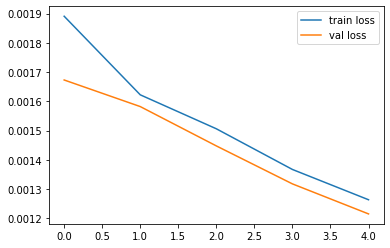

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt


os.environ['CUDA_VISIBLE_DEVICES'] = '6'
cur_path = os.getcwd()
input_img = tf.keras.Input(shape=(64, 64, 1))

hidden_num = 128

x = layers.Conv2D(hidden_num*2, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(hidden_num//4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

flatten = tf.keras.layers.Flatten()(encoded)
latent = tf.keras.layers.Dense(512, activation="relu")(flatten)
reshape = tf.keras.layers.Reshape((8, 8, 8))(latent)

x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(reshape)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(hidden_num*2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x)

opt = Adam(lr = 0.0003)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer=opt, loss='mse')



# x_train = np.load(cur_path + '/data/power_maps_0_500_256.npz')['arr_0'][:, :, :, None][:, ::4, ::4, :]
x_train = np.load(cur_path + '/data/power_maps_0_10000_256.npz')['arr_0'][:, :, :, None][:, ::4, ::4, :]

P_max = x_train.max()
P_min = x_train.min()
x_train = (x_train - P_min) / (P_max - P_min)

test_idx = np.random.choice(x_train.shape[0], x_train.shape[0]//10, replace=False)
train_idx = np.setxor1d(np.arange(x_train.shape[0]), test_idx)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir = work_dir + '/logs'),
]


history = autoencoder.fit(x_train[train_idx, :,:,:], x_train[train_idx, :,:,:],
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_train[test_idx, :,:,:], x_train[test_idx, :,:,:]),
                callbacks=my_callbacks)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss)
ax.plot(val_loss)
ax.legend(['train loss', 'val loss'])

In [25]:
ckpt_dir

'/home/ansysai/HaiyangHe/ML_Solver_Fluent/CNN_Sim/ckpt/'

In [6]:
import numpy as np
cur_path = os.getcwd()

x_train = np.load(cur_path + '/data/power_maps_0_10000_256.npz')['arr_0'][:, :, :, None][:, ::4, ::4, :]



In [8]:
test_idx.shape

(1000,)

In [14]:
x_train.shape

(10000, 64, 64, 1)